In [31]:
# Importa librerías
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import featuretools as ft
import utilities
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

In [28]:
train = pd.read_csv('santander-customer-transaction-prediction/train.csv')

train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Utilizando FeatureTools

Usamos la herramienta FeatureTools para ver si puede crear nuevos campos a partir de los actuales. 

In [29]:
# Carga FeatureTools
es = ft.EntitySet(id = 'transactions')
es.entity_from_dataframe(entity_id = 'transactions', dataframe = train, index = 'ID_code')

# Corre DFS con transformación de primitivas
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'transactions', max_depth = 1,
                                     agg_primitives=["sum", "min", "max", "skew", "trend", "mode", "median", "std", "sum"])

feature_matrix

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
train_10,0,5.0702,-0.5447,9.5900,4.2987,12.3910,-18.8687,6.0382,14.3797,-0.4711,...,7.2780,8.0819,0.2139,-0.0761,14.9585,-1.2160,6.6576,9.2553,14.2914,-7.6652
train_100,0,9.4702,-4.0205,9.3693,9.4134,9.8362,-16.4643,6.0796,17.8444,-0.4833,...,2.7162,6.3275,3.8694,7.0642,21.1426,-0.6775,6.5296,7.7402,12.1681,-6.8294
train_1000,0,8.5826,-8.3369,10.1053,10.2773,12.3695,-0.5861,4.6452,21.4091,-4.7384,...,2.0163,9.2570,0.9863,3.7194,13.8578,0.8077,10.1349,9.7018,17.7495,-9.2302
train_10000,0,10.1470,-3.8678,9.1487,3.7897,14.2731,-11.8442,4.6582,19.7861,4.2257,...,-0.3166,3.4004,-1.6575,8.1963,13.9492,-2.2748,11.6643,8.2042,18.1922,0.7171
train_100000,0,7.0987,-2.0057,8.0500,7.8754,13.2961,-10.2442,4.7920,17.5372,4.5317,...,-4.2302,7.0876,4.2954,6.5649,18.0063,2.1031,12.1840,9.3047,16.3529,-6.0353
train_100001,0,11.2321,0.8326,10.9387,7.4749,9.6369,-19.2275,6.1119,15.7646,-2.0717,...,0.2137,6.3294,0.1274,4.8939,17.6979,-2.3592,-0.7314,8.0394,19.8543,-5.5144
train_100002,0,9.1928,2.8052,12.4876,8.5139,13.9320,-7.8300,4.6258,14.9243,-5.1789,...,-0.8494,3.9726,1.7904,7.1780,18.9760,0.0822,2.7941,7.7081,17.9709,-8.8970


In [30]:
feature_defs

[<Feature: target>,
 <Feature: var_0>,
 <Feature: var_1>,
 <Feature: var_2>,
 <Feature: var_3>,
 <Feature: var_4>,
 <Feature: var_5>,
 <Feature: var_6>,
 <Feature: var_7>,
 <Feature: var_8>,
 <Feature: var_9>,
 <Feature: var_10>,
 <Feature: var_11>,
 <Feature: var_12>,
 <Feature: var_13>,
 <Feature: var_14>,
 <Feature: var_15>,
 <Feature: var_16>,
 <Feature: var_17>,
 <Feature: var_18>,
 <Feature: var_19>,
 <Feature: var_20>,
 <Feature: var_21>,
 <Feature: var_22>,
 <Feature: var_23>,
 <Feature: var_24>,
 <Feature: var_25>,
 <Feature: var_26>,
 <Feature: var_27>,
 <Feature: var_28>,
 <Feature: var_29>,
 <Feature: var_30>,
 <Feature: var_31>,
 <Feature: var_32>,
 <Feature: var_33>,
 <Feature: var_34>,
 <Feature: var_35>,
 <Feature: var_36>,
 <Feature: var_37>,
 <Feature: var_38>,
 <Feature: var_39>,
 <Feature: var_40>,
 <Feature: var_41>,
 <Feature: var_42>,
 <Feature: var_43>,
 <Feature: var_44>,
 <Feature: var_45>,
 <Feature: var_46>,
 <Feature: var_47>,
 <Feature: var_48>,
 <Feature:

*FeatureTools* no genera variables nuevas para el set de datos a partir de datos agregados, indicando que no contienen información relevante. Se intentó correr *FeatureTools* con transitive primitives en el set de datos *undersampled* pero no generó features importantes.

# Estudio de importancia de variables 

Se utiliza un algoritmo de RandomForest para encontrar las 10 variables más importantes. La razón de la elección de este algoritmo es que los algoritmos de árbol de decisión se deshacen de las variables que contienen menos información durante el entrenamiento, eligiendo aquellas que más información tienen para la clasificación primero. Esto nos permitirá verificar cuáles variables son las más importantes para el problema. Inicialmente utilizamos el set de datos desbalanceado para ver la informaicón original.

In [33]:
# Split de casos de prueba y test
X = train.drop(["ID_code", "target"], axis=1).values
Y = train.target.values

# Split 2/3 entrenamiento, 1/3 validación
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

# Algoritmo de clasificación RandomForest
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, {'min_samples_leaf': [20, 25]}, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))
grid.fit(train_X, train_Y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

Mejor score:  0.5000371280709396


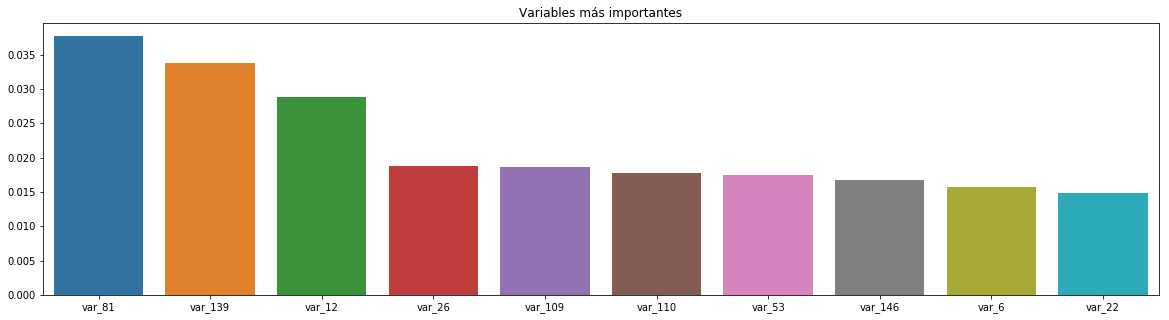

In [35]:
# Mejor score
print("Mejor score: ", grid.best_score_)

# Features más importantes para RandomForest
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:10]
feature_names = train.drop(["ID_code","target"], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Variables más importantes");

Se observa que `var_81`, `var_12` y `var_139` son las dos variables que más influyen en la determinación de las clases.

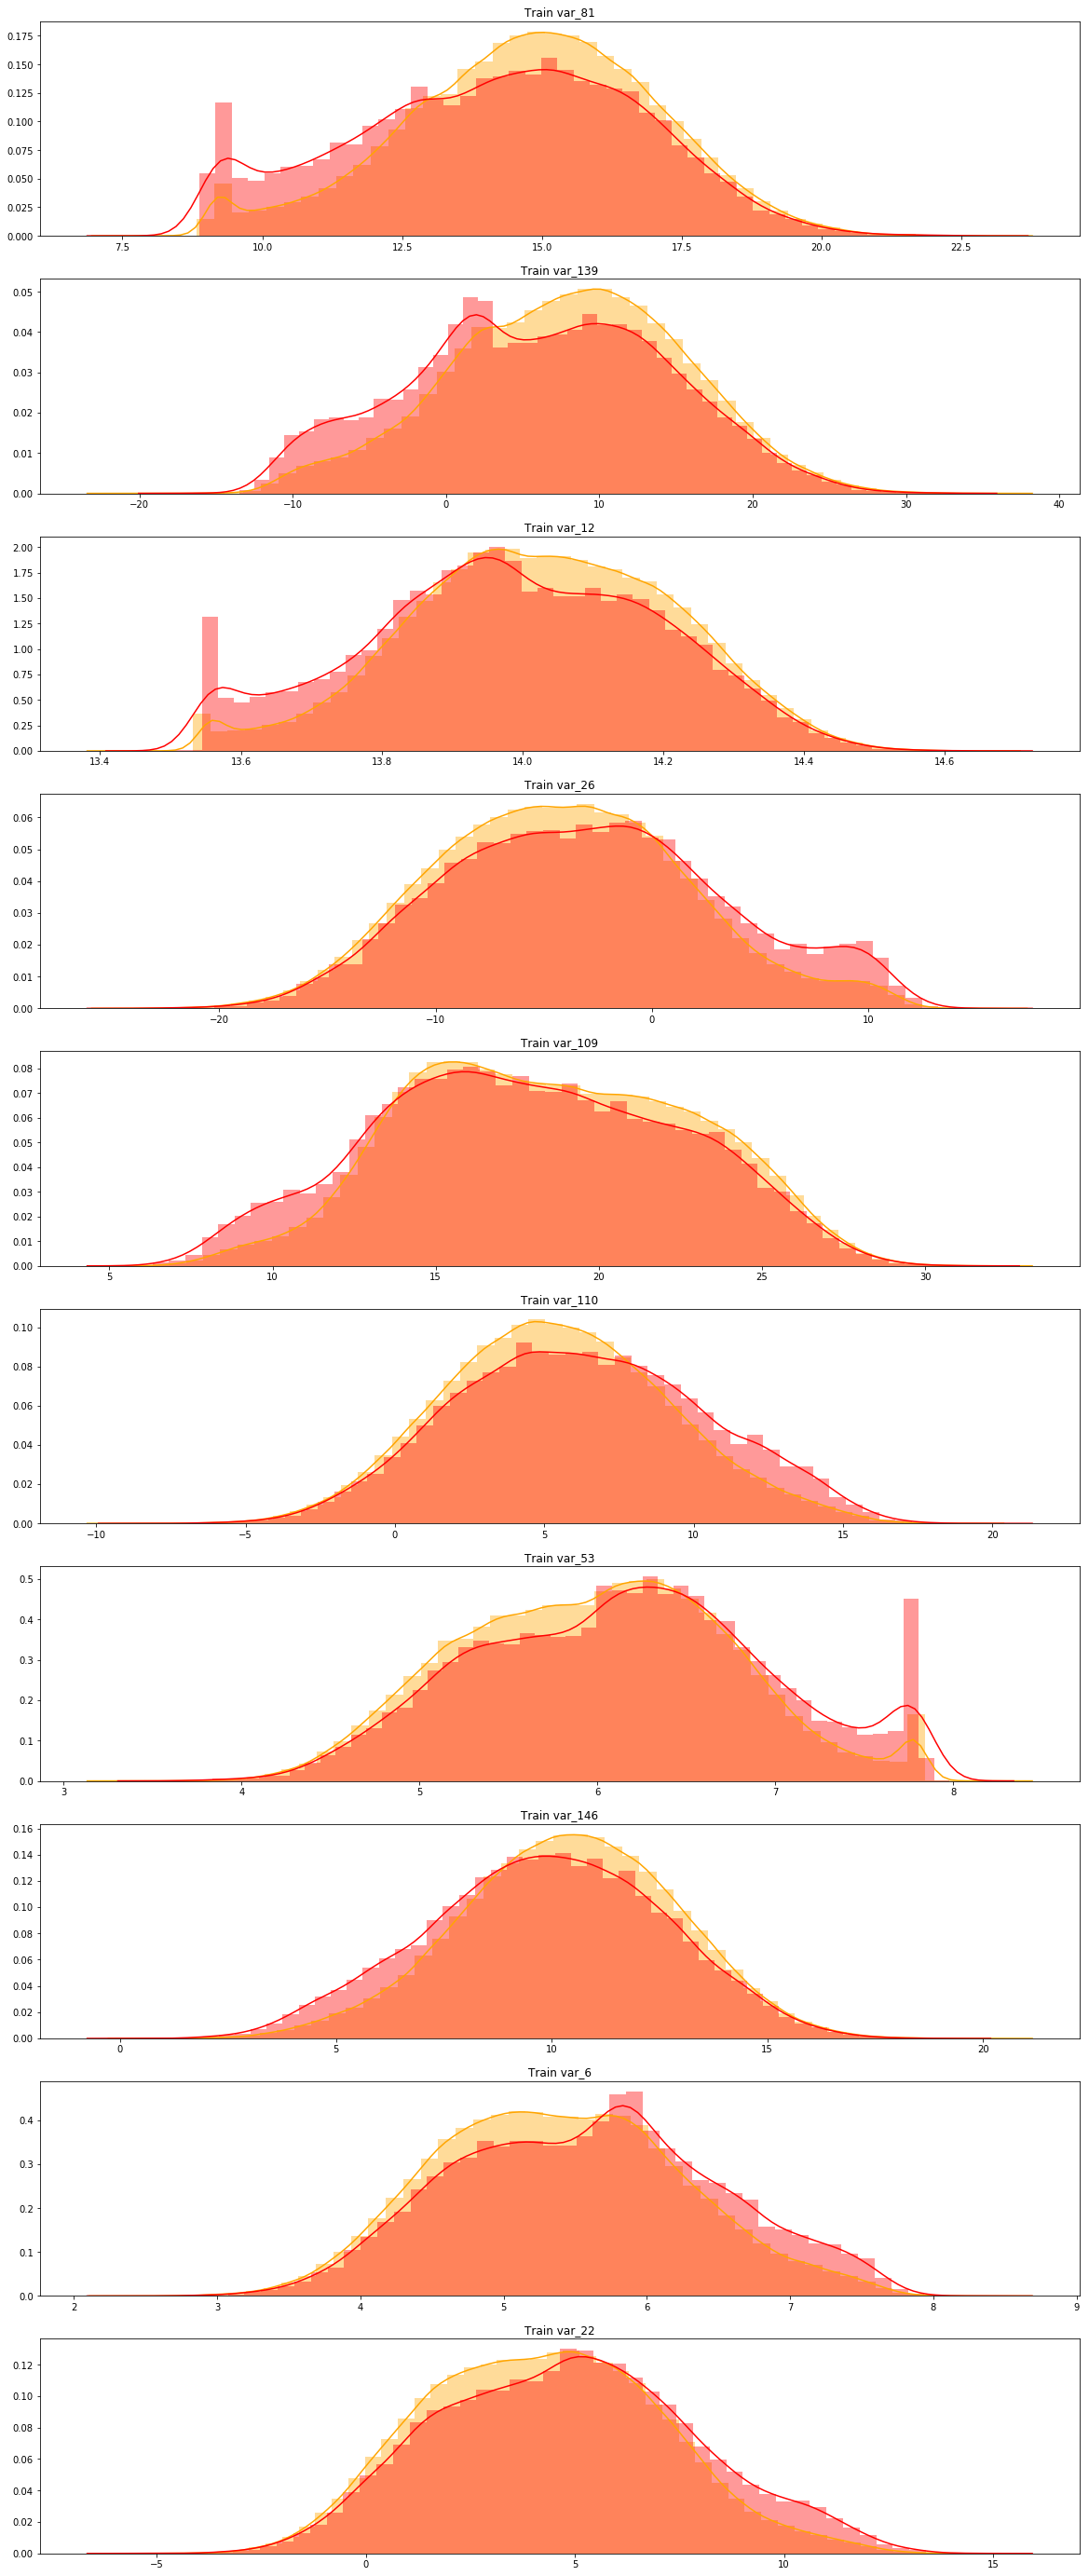

In [36]:
# Distribución de features más importantes con histogramas, en grande
fig, ax = plt.subplots(10,1,figsize=(20,5*10))

for n in range(10):
    sns.distplot(train.loc[train.target==0, feature_names[idx][n]], ax=ax[n], color="Orange", norm_hist=True)
    sns.distplot(train.loc[train.target==1, feature_names[idx][n]], ax=ax[n], color="Red", norm_hist=True)
    ax[n].set_title("Train {}".format(feature_names[idx][n]))
    ax[n].set_xlabel("")

No handles with labels found to put in legend.


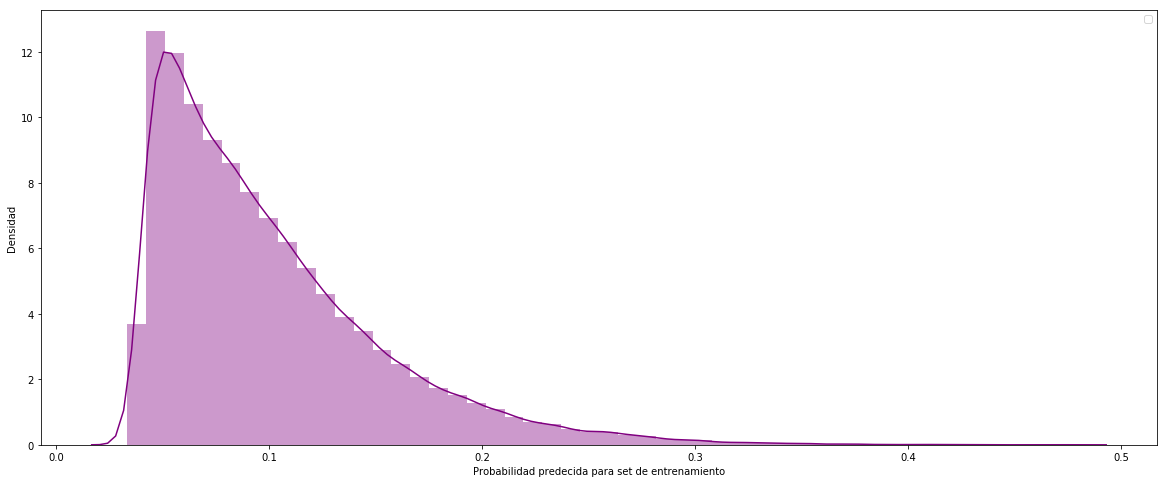

In [37]:
# Performance de RandomForest
y_prob = grid.predict_proba(test_X)

fig, ax = plt.subplots(1,1,figsize=(20,8))
sns.distplot(y_prob[:,1], norm_hist=True,
             ax=ax, color="purple")
ax.set_xlabel("Probabilidad predecida para set de entrenamiento");
ax.set_ylabel("Densidad");
ax.legend();

### Estudio de importancia de variables con set de datos balanceados

#### Set de datos *underbalanced*

In [40]:
train_undersampled = pd.read_csv("santander-customer-transaction-prediction/train_undersampled.csv")
train_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40196 entries, 0 to 40195
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 61.9+ MB


In [56]:
# Split de casos de prueba y test
X = train_undersampled.drop(["ID_code", "target"], axis=1).values
Y = train_undersampled.target.values

# Split 2/3 entrenamiento, 1/3 validación
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

# Algoritmo de clasificación RandomForest
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, {'min_samples_leaf': [20, 25]}, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))
grid.fit(train_X, train_Y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.8s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

Mejor score:  0.7006795172181374


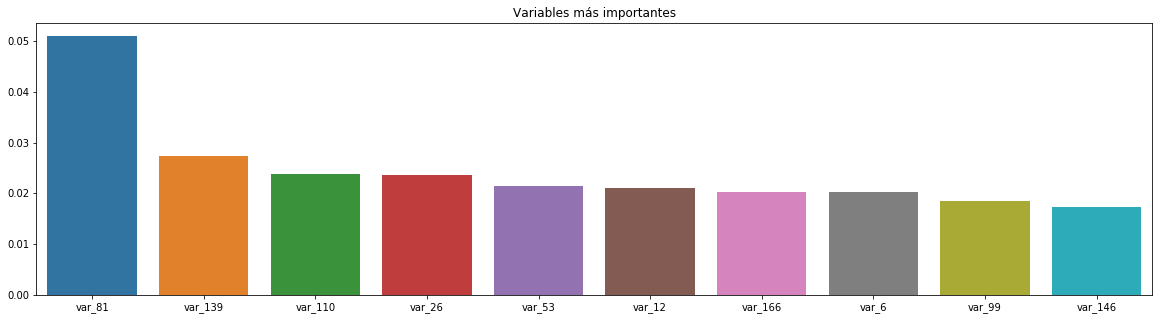

In [42]:
# Mejor score
print("Mejor score: ", grid.best_score_)

# Features más importantes para RandomForest
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:10]
feature_names = train.drop(["ID_code","target"], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Variables más importantes");

No se ven cambios significativos entre las variables más importantes

#### Set de datos *overbalanced*

In [45]:
train_oversampled = pd.read_csv("santander-customer-transaction-prediction/train_oversampled.csv")
train_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359804 entries, 0 to 359803
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 554.5+ MB


In [54]:
# Split de casos de prueba y test
X = train_oversampled.drop(["ID_code", "target"], axis=1).values
Y = train_oversampled.target.values

# Split 2/3 entrenamiento, 1/3 validación
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

# Algoritmo de clasificación RandomForest
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, {'min_samples_leaf': [20, 25]}, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))
grid.fit(train_X, train_Y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

Mejor score:  0.8351958783413809


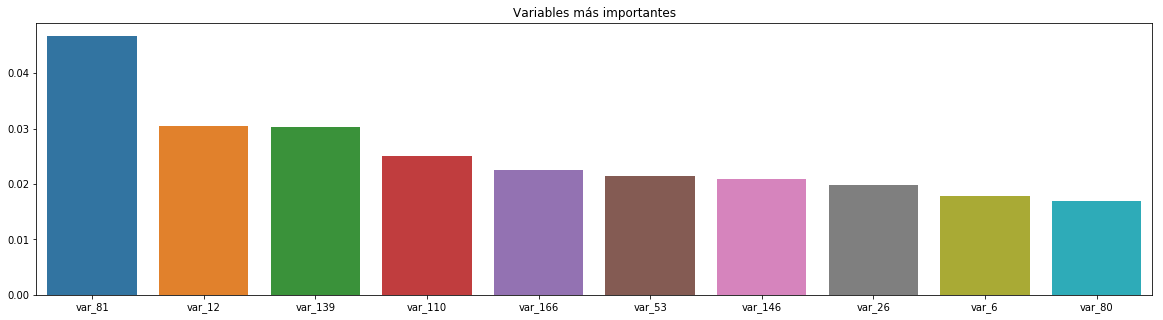

In [49]:
# Mejor score
print("Mejor score: ", grid.best_score_)

# Features más importantes para RandomForest
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:10]
feature_names = train_oversampled.drop(["ID_code","target"], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Variables más importantes");

Tampoco se ven cambios significativos en cuanto a las variables más importantes. La variable `var_81` sigue siendo por mucho la más importante para este algoritmo

# Redondeo y agrupación en bins

Se pasa a ver el resultado de agrupar los valores de las features en bins y redondeando. Utilizamos el set de datos *undersampled* para agilizar cálculos.

In [58]:
original_features = train.drop(["target", "ID_code"], axis=1).columns.values

encoder = LabelEncoder()
for your_feature in original_features:
    train[your_feature + "_qbinned"] = pd.qcut(
        train.loc[:, your_feature].values,
        q=10,
        labels=False
    )
    train[your_feature + "_qbinned"] = encoder.fit_transform(
        train[your_feature + "_qbinned"].values.reshape(-1, 1)
    )
    
    
    train[your_feature + "_rounded"] = np.round(train.loc[:, your_feature].values)
    train[your_feature + "_rounded_10"] = np.round(10*train.loc[:, your_feature].values)
    train[your_feature + "_rounded_100"] = np.round(100*train.loc[:, your_feature].values)

In [59]:
# Split de casos de prueba y test
X = train.drop(["ID_code", "target"], axis=1).values
Y = train.target.values

# Split 2/3 entrenamiento, 1/3 validación
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)

forest = RandomForestClassifier(max_depth=15, n_estimators=15, min_samples_leaf=20,
                                n_jobs=-1)
grid = GridSearchCV(forest, {'min_samples_leaf': [20, 25]}, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))
grid.fit(train_X, train_Y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  3.3min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

Mejor score:  0.5000742561418791


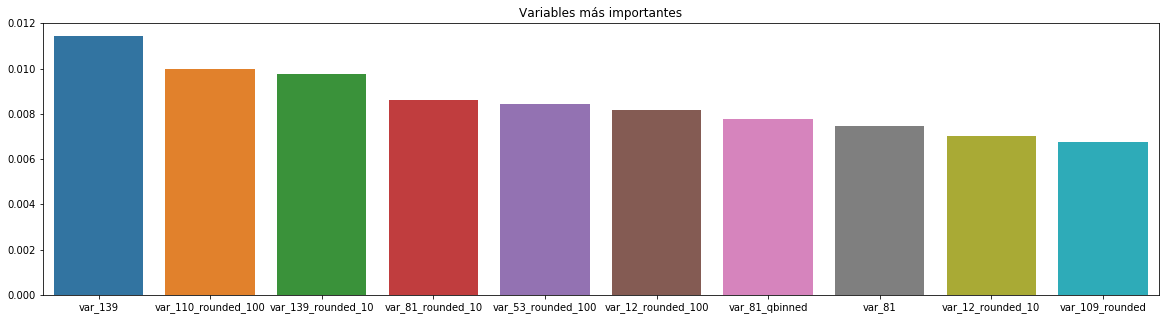

In [61]:
# Mejor score
print("Mejor score: ", grid.best_score_)

# Features más importantes para RandomForest
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:10]
feature_names = train.drop(["ID_code","target"], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Variables más importantes");

No vemos una variable que incremente su importancia. De hecho, vemos que las variables todas han disminuido y ahora lidera la variable `var_139`. Se elige entonces no modificar las variables originales y su tipo.